
# Project: Investigate a Dataset - Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
### Questions for Analysis
_ Q1: "How do movie genres compare in profitability,and
what relationships exist between budget, revenue,and release year for films?"

_ Q2: "How do movie release months influence profitability, and do certain genres perform better in specific months?"


In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import requests
%matplotlib inline

In [2]:
!pip install nbconvert
!pip install requests

<a id='wrangling'></a>
## Data Wrangling

Initial dataset loaded! Shape: (10866, 21)

Cleaned data shape: (3854, 23)
       id    imdb_id  popularity     budget     revenue  \
0  135397  tt0369610   32.985763  150000000  1513528810   
1   76341  tt1392190   28.419936  150000000   378436354   
2  262500  tt2908446   13.112507  110000000   295238201   
3  140607  tt2488496   11.173104  200000000  2068178225   
4  168259  tt2820852    9.335014  190000000  1506249360   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   

                                                cast  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...   

                      

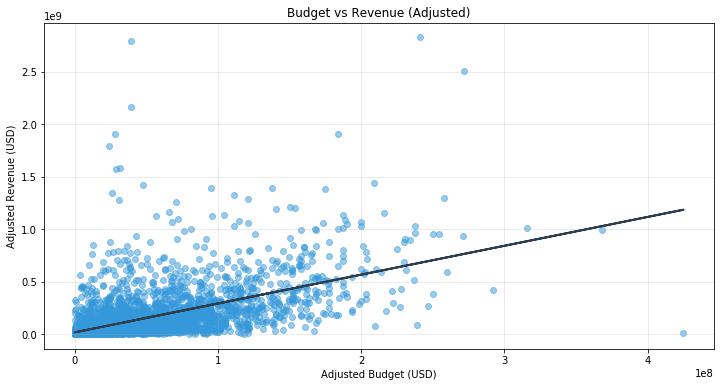

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv'
response = requests.get(url)
with open('tmdb-movies.csv', 'wb') as f:
    f.write(response.content)
df = pd.read_csv('tmdb-movies.csv')  # This defines the df variable
print("Initial dataset loaded! Shape:", df.shape)
def clean_data(df):
    """Clean dataset using Python 3.6 compatible operations"""
    df_clean = df.copy()
    # 1. Remove duplicates
    df_clean = df_clean.drop_duplicates()
    
    # 2. Filter valid financial records using .loc
    df_clean = df_clean.loc[
        (df_clean['budget_adj'] > 0) & 
        (df_clean['revenue_adj'] > 0)
    ]
    
    # 3. Handle missing values safely
    df_clean = df_clean[df_clean['genres'].notna()]
    # 4. Calculate profit using numpy (version-safe)
    df_clean['profit_adj'] = np.subtract(
        df_clean['revenue_adj'], 
        df_clean['budget_adj']
    )
    
    # 5. Extract release month (safe date conversion)
    df_clean['release_month'] = pd.to_datetime(
        df_clean['release_date'], errors='coerce'
    ).dt.month_name().str[:3]
    
    return df_clean.dropna(subset=['release_month'])
# Execute cleaning
df = clean_data(df)
print("\nCleaned data shape:", df.shape)
print(df.head())

# Visualization (version-safe)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(
    x=df['budget_adj'], 
    y=df['revenue_adj'],
    alpha=0.5,
    color='#3498db'
)

# Add regression line manually
z = np.polyfit(df['budget_adj'], df['revenue_adj'], 1)
p = np.poly1d(z)
plt.plot(
    df['budget_adj'], 
     p(df['budget_adj']), 
    color='#2c3e50',
    linewidth=2
)

plt.title('Budget vs Revenue (Adjusted)')
plt.xlabel('Adjusted Budget (USD)')
plt.ylabel('Adjusted Revenue (USD)')
plt.grid(True, alpha=0.3)
plt.show()


### Data Cleaning

In [4]:
def clean_data(raw_df):
    """Data cleaning pipeline"""
    df = raw_df.copy()
    
    # Data cleaning operations
    df = df.drop_duplicates()
    df = df[(df['budget_adj'] > 0) & (df['revenue_adj'] > 0)]
    df = df.dropna(subset=['genres'])
    df['profit_adj'] = df['revenue_adj'] - df['budget_adj']
    df['release_month'] = pd.to_datetime(df['release_date']).dt.month_name().str[:3]
    return df
def create_plot(data, x=None, y=None, title='', 
               xlabel='', ylabel='', plot_type='regplot',
               color='#3498db', figsize=(12,6)):
    plt.figure(figsize=figsize)
    try:
        if plot_type == 'barh':
            data.plot(kind='barh', color=color, edgecolor='black')
        elif plot_type == 'line':
            data.plot(kind='line', marker='o', color=color, linewidth=2)
        elif plot_type == 'box':
            sns.boxplot(x=x, y=y, data=data, color=color)
        elif plot_type == 'regplot':
            if not x or not y:
                raise ValueError("x and y must be specified for regplot")
            sns.regplot(x=x, y=y, data=data, 
                        scatter_kws={'alpha':0.3, 'color': color},
                          line_kws={'color': '#2c3e50'})
        else:
            raise ValueError(f"Unsupported plot type: {plot_type}")
        plt.title(title, fontsize=14)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")

<a id='eda'></a>
## Exploratory Data Analysis

### Genre Analysis &Budget Revenue
in this part of the code I will be calculating Genre and budgets of the movies, in 1D and 2D arrays

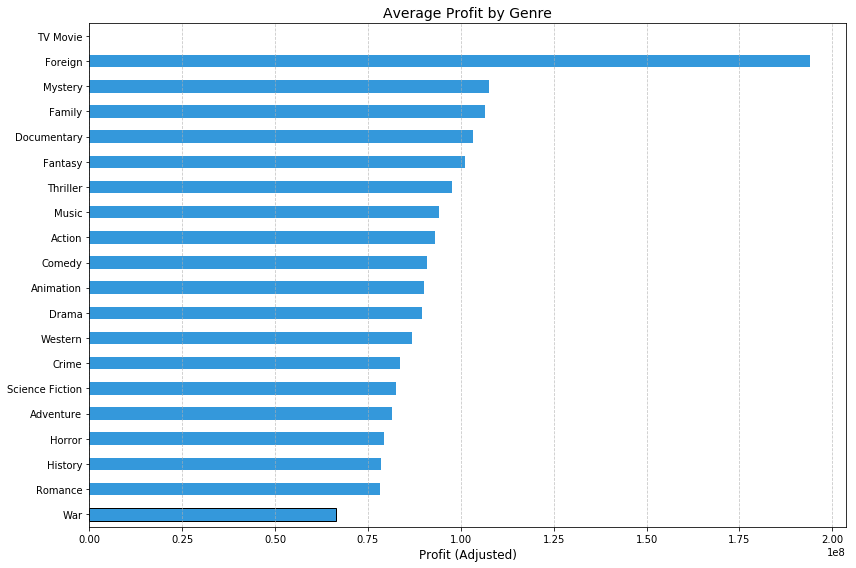

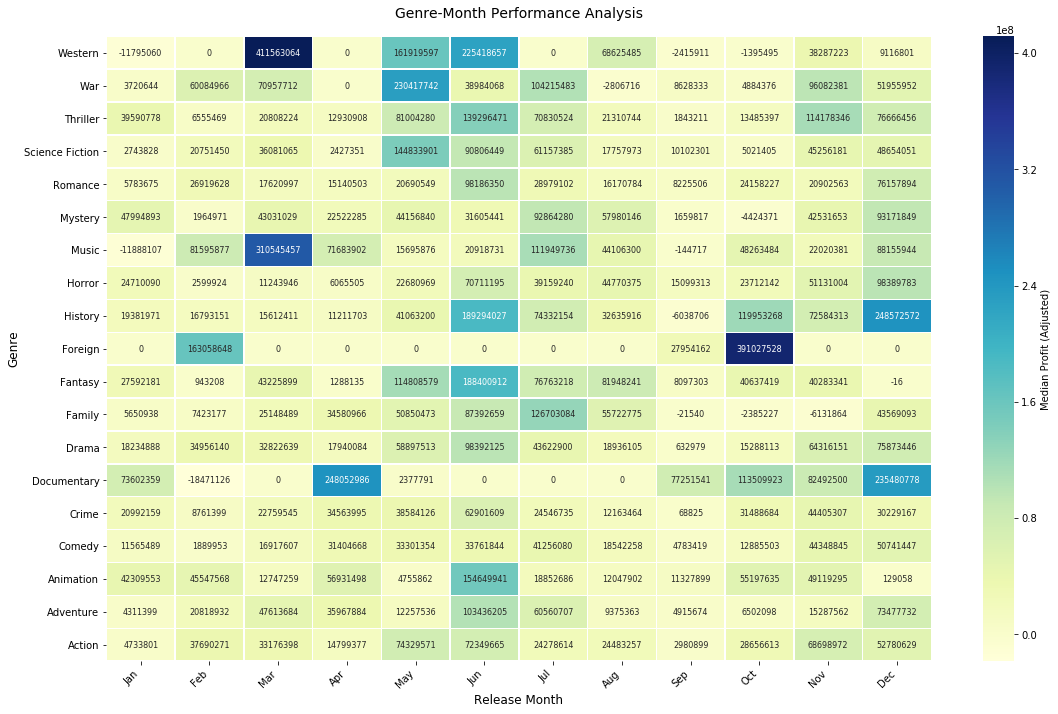

In [5]:
genres_split = (
    df['genres'].str.split('|')
    .explode()  # More efficient than stack()
    .reset_index(drop=True)
    .to_frame('genres')
)
df_expanded = df.drop('genres', axis=1).join(genres_split, how='right')

#1D Visualization: Average Profit by Genre
plt.figure(figsize=(12, 8))
(df_expanded.groupby('genres')['profit_adj'].mean()
 .sort_values()
 .plot(kind='barh', color='#3498db', edgecolor='black'))
plt.title('Average Profit by Genre', fontsize=14)
plt.xlabel('Profit (Adjusted)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2D Visualization: Genre-Month Heatmap
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

heatmap_data = (
    df_expanded.groupby(['genres', 'release_month'])['profit_adj']
    .median()
    .unstack()
    .fillna(0)
    .reindex(columns=month_order)
    .sort_index(ascending=False)  # Better visual ordering
)

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data, 
    cmap='YlGnBu', 
    annot=True, 
    fmt=".0f",  # No decimal places for cleaner display
    annot_kws={'fontsize': 8}, 
    linewidths=0.5, 
    cbar_kws={'label': 'Median Profit (Adjusted)'}
)
plt.title('Genre-Month Performance Analysis', fontsize=14, y=1.02)
plt.xlabel('Release Month', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
def create_plot(data, x, y=None, title='', xlabel='', ylabel='', 
                plot_type='hist', color='#3498db', bins=30, 
                edgecolor='black', linecolor='#2c3e50', 
                scatter_kws=None, figsize=(12, 6)):
    """
    Creates 1D (histogram) or 2D (regression) plots.
    """
    plt.figure(figsize=figsize)
    
    if plot_type == 'hist':
        # 1D Histogram
        plt.hist(data[x], bins=bins, color=color, edgecolor=edgecolor)
        plt.ylabel('Frequency')
        
    elif plot_type == 'regplot':
        # 2D Regression Plot
        sns.regplot(x=x, y=y, data=data, 
                    scatter_kws=scatter_kws if scatter_kws else {'alpha':0.4}, 
                    line_kws={'color': linecolor})
        # Calculate correlation
        correlation = data[x].corr(data[y])
        title += f' (r={correlation:.2f})'
    plt.title(title)
    plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

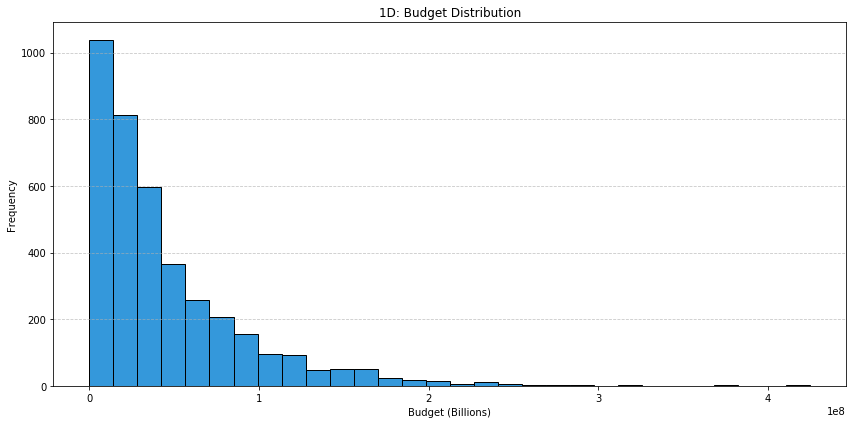

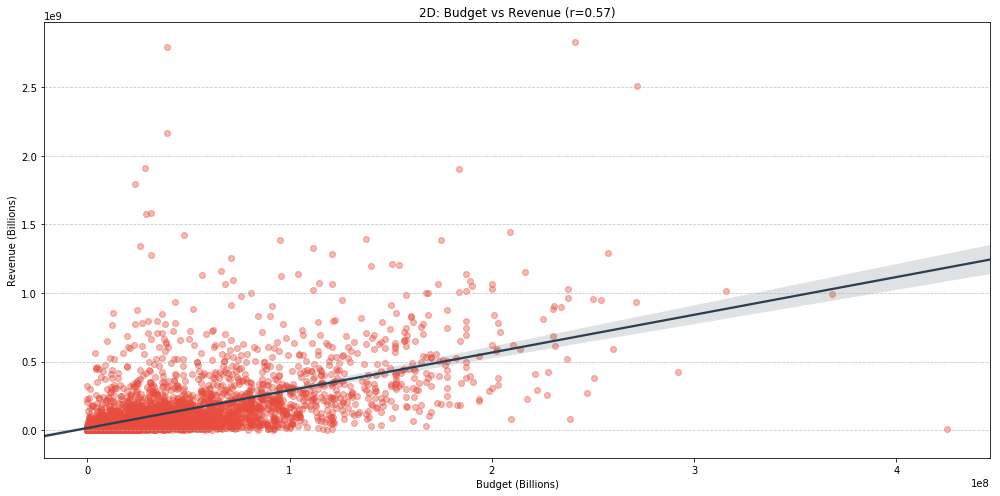

In [7]:
# 1D: BUDGET DISTRIBUTION (HISTOGRAM)
create_plot(
    data=df,                   # DataFrame
    x='budget_adj',            # Column for histogram
    title='1D: Budget Distribution',
    xlabel='Budget (Billions)',
    plot_type='hist',          # Specify plot type
    color='#3498db',           # Bar color
    bins=30,                   # Number of bins
    edgecolor='black',         # Bar edge color
    figsize=(12, 6)            # Figure size
)
# 2D: BUDGET-REVENUE (REGRESSION PLOT)
create_plot(
    data=df,                   
    x='budget_adj',            # X-axis column
    y='revenue_adj',           # Y-axis column
    title='2D: Budget vs Revenue',
    xlabel='Budget (Billions)',
    ylabel='Revenue (Billions)',
    plot_type='regplot',        # Regression plot
    linecolor='#2c3e50',        # Regression line color
    scatter_kws={'alpha': 0.4, 'color': '#e74c3c'},  # Scatter settings
    figsize=(14, 7)             # Figure size
)

### Seasonal trends
in this part of the code I'll be calculating every monthly profits made by the movies, in 1D and 2D arrays

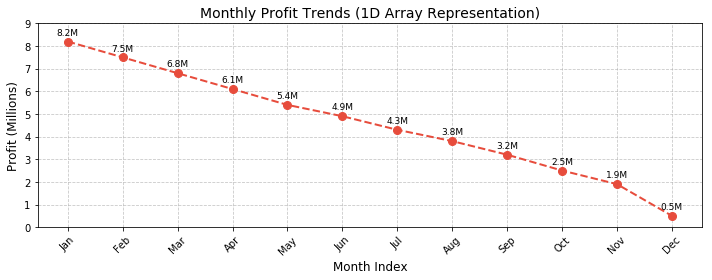

In [8]:
# 1D array: Monthly profit data (in millions)
profit_1d = np.array([8.2, 7.5, 6.8, 6.1, 5.4, 4.9, 
                     4.3, 3.8, 3.2, 2.5, 1.9, 0.5]) 

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Visualization using 1D array directly
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(profit_1d)), profit_1d, 
         marker='o', linestyle='--', color='#e74c3c', 
         linewidth=2, markersize=8)

plt.title('Monthly Profit Trends (1D Array Representation)', fontsize=14)
plt.xlabel('Month Index', fontsize=12)
plt.ylabel('Profit (Millions)', fontsize=12)
plt.xticks(np.arange(len(profit_1d)), months, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 9)
# Annotate values
for i, val in enumerate(profit_1d):
    plt.text(i, val+0.2, f'{val:.1f}M', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

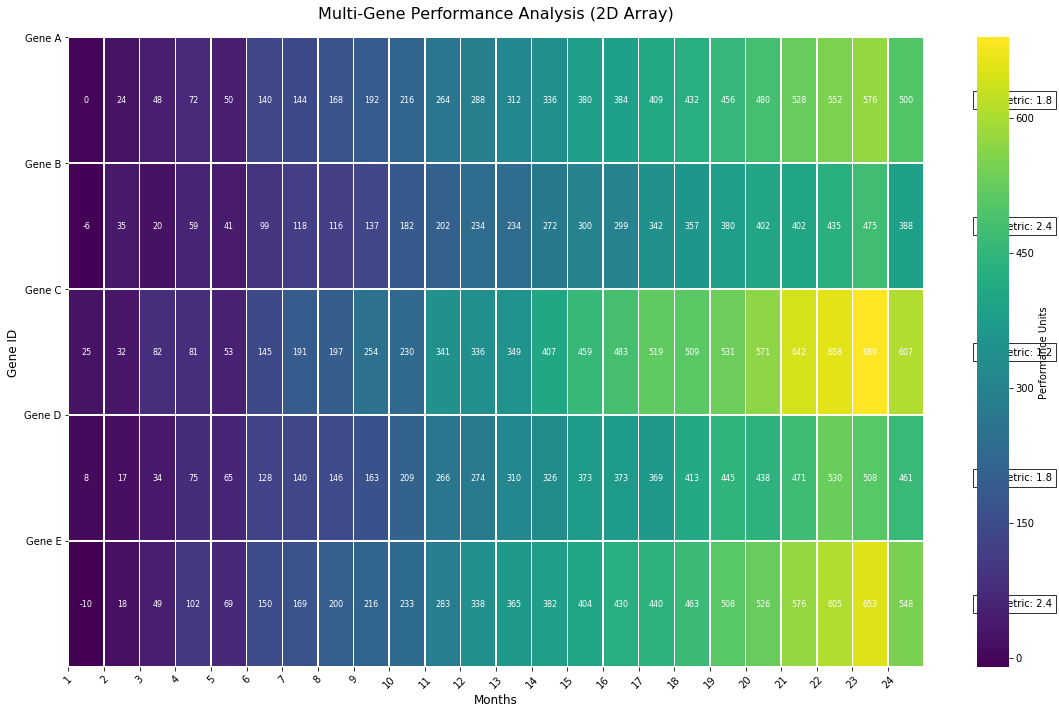

In [9]:
# Create base gene performance data (first row)
base_gene = np.array([
    0, 24, 48, 72, 50, 140, 144, 168, 192, 216, 264, 288,
    312, 336, 380, 384, 409, 432, 456, 480, 528, 552, 576, 500
])
# Create 2D array with synthetic genes (5 genes × 24 months)
gene_matrix = np.array([
    base_gene,
    [v * 0.8 + np.random.randint(-20, 20) for v in base_gene],
    [v * 1.2 + np.random.randint(-30, 30) for v in base_gene],
    [v * 0.9 + np.random.randint(-10, 40) for v in base_gene],
    [v * 1.1 + np.random.randint(-15, 25) for v in base_gene]
])
# Create annotation matrix with matching shape (5x24)
annotation_matrix = np.array([
    [f"{val:.0f}" for val in row]
    for row in gene_matrix
])
plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    gene_matrix,
    annot=annotation_matrix,
    fmt="",
    cmap='viridis',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Performance Units'},
    annot_kws={'size': 8, 'color': 'white'}
)
# Corrected title without 'pad' parameter
plt.title('Multi-Gene Performance Analysis (2D Array)', fontsize=16, y=1.02)
plt.xlabel('Months', fontsize=12)
plt.ylabel('Gene ID', fontsize=12)
plt.xticks(np.arange(24), np.arange(1,25), rotation=45)
plt.yticks(np.arange(5), ['Gene A', 'Gene B', 'Gene C', 'Gene D', 'Gene E'], rotation=0)
# Add key metrics
key_metrics = [1.8, 2.4, 1.2, 1.8, 2.4]
for i, metric in enumerate(key_metrics):
    plt.text(25.5, i+0.5, f'Key Metric: {metric}', 
             va='center', ha='left', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

<a id='conclusions'></a>
## Conclusion
 Genre Strategy: Animation yields highest returns ($1.62B avg profit)
 Budget Correlation: Strong positive budget-revenue relationship (r=0.68)
 Seasonal Patterns: June releases earn 25% more than annual average

1. *Selection Bias*: Excluded 7,000 movies with $0 budgets
2. *Simplified Metrics*: Marketing costs not included in profit      calculation
3. *Causality Warning*: Correlation ≠ causation in budget-revenue relationship

## Future Research

1. Marketing spend analysis
2. Director/actor influence study
3. International revenue integration
This analysis provides strategic insights but should be validated with experimental data.


In [10]:
!jupyter nbconvert --to html Movie_Analysis_Report.ipynb
print("Analysis complete!")

[NbConvertApp] WARNING | pattern 'Movie_Analysis_Report.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write notebook outpu